In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import math as ma
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import autograd.numpy as np

# To do elementwise differentiation:
from autograd import elementwise_grad as egrad 
from autograd import grad

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
def noiseGeneration(z_input, scaling = 0.1):
    np.random.seed(644)
    
    nosyZ= z_input + np.random.randn(*z_input.shape) * scaling
    return nosyZ

In [2]:
class NN:
    
    def __init__(self,
                 X_train,
                 X_test,
                 z_train,
                 z_test,
                 n_hidden_layers,
                 n_hidden_neurons,
                 act_function,
                 n_outputs,
                 innit,
                 classify,
                 out_func):

        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        
        
        if len(X_train.shape) > 1:
            self.n_inputs, self.n_features = self.X_train.shape
        if len(X_train.shape) == 1:   
            self.n_inputs = len(X_train)
            self.n_features = 1
        
        self.n_outputs = n_outputs  
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_neurons = n_hidden_neurons
        
        
        self.weights = self.weight_create(innit)
        self.biases = self.bias_create()
        self.classify = classify
        
        if classify == 1:
            
            if (out_func == "tanh"):
                self.out_func = self.tanh
                self.check = "tan"
            elif(out_func == "Sigmoid"):
                self.out_func = self.sigmoid
                self.check = "sig"
            else:
                print("Choose tanh or Sigmoid")

        
        if(act_function == "Sigmoid"):
            self.act_function= self.sigmoid
            self.d_act  = self.d_sigmoid
        elif(act_function  == "RELU"):
            self.act_function = self.relu
            self.d_act = self.d_relu
        elif(act_function  == "LRELU"):
            self.act_function= self.lrelu
            self.d_act  = self.d_lrelu
        elif(act_function  == "tanh"):
            self.act_function = self.tanh
            self.d_act  = self.d_tanh
        else:
            print("please choose ,Sigmoid,RELU,LRELU or tanh")
            quit()

    def weight_create(self,innit):  # initilazing weights. all at random between 0 and 1
        weights = []
        if (innit == "explode-gradient"):
            
            In_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
            weights.append(In_weights)
            #Weights between hidden layers
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.randn(self.n_hidden_neurons, self.n_hidden_neurons) )
            # weights out of last activation function   
            Out_weights = np.random.randn(self.n_hidden_neurons, self.n_outputs) 
            weights.append(Out_weights) 
            return weights
        elif (innit == "Xavier"):
            In_weights = np.random.normal(0, np.sqrt(1.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights)
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights)
            return weights
        elif(innit == "He"):
            In_weights = np.random.normal(0, np.sqrt(2.0/self.n_features), (self.n_features, self.n_hidden_neurons))
            weights.append(In_weights) #First weights
            for i in range(1, self.n_hidden_layers):
                weights.append(np.random.normal(0, np.sqrt(2.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_hidden_neurons)))
            Out_weights = np.random.normal(0, np.sqrt(1.0/self.n_hidden_neurons), (self.n_hidden_neurons, self.n_outputs))
            weights.append(Out_weights) #last weights
            return weights
        else:
            return print("not a valid weight initilization")

    def bias_create(self):  # Starting biases all at zero
        biases = []
        #biases for all hidden layers and first hidden layer
        for i in range(0, self.n_hidden_layers):
            biases.append(np.zeros(self.n_hidden_neurons))
        #Biases for output nodes
        O_b = np.zeros(self.n_outputs)
        biases.append(O_b)
        return biases

    def sigmoid(self, x):  # Active function + derivative
        return 1.0/(1.0 + np.exp(-x))
    def d_sigmoid(self,x):
        return self.sigmoid(x)*(1.0-self.sigmoid(x))

    def relu(self, x): # Active function + derivative
        return x * (x > 0)
       
            
          
    def d_relu(self,x):
        return 1.0 * (x > 0)
        
        

    def lrelu(self, x):# Active function + derivative
        alpha = 0.01
        y1 = ((x >= 0) * x)
        y2 = ((x < 0) * x * alpha)
        y = y1 + y2
        return y
    def d_lrelu(self, x):
        alpha = 0.01
        dy1 =((x >= 0) * 1.0)
        dy2 = ((x < 0) * alpha)
        dy = dy1 + dy2
        return dy

    def tanh (self,x): # Active function + derivative
        return np.tanh(x)
    def d_tanh(self,x):
        y = np.tanh(x)
        dy = 1 - y**2
        return dy


    def mini_batch_creator(self,X, y, batch_size):
        mini_batches = [] # empty list for the mini batchess
        if self.n_features == 1:
            data_matrix = np.hstack((X.reshape(-1, 1), y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
        if self.n_features != 1:
            data_matrix = np.hstack((X, y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
            
        

        np.random.shuffle(data_matrix) # would not be stochastic if it didnt include random. 

        m = data_matrix.shape[0] // batch_size # number of minibatches number of rows/datapoints divided by selected batchsize
        i=0
        for i in range(m):
            mini_batch = data_matrix[i * batch_size:(i + 1)*batch_size, :]#creating a mini batch
            X_mini = mini_batch[:, :-1] #evry thing except the last column
            Y_mini = mini_batch[:, -1] #exclusively the last column
            mini_batches.append((X_mini, Y_mini)) # has 2 arrays, first array contains the minibatches for x and the second for y
        if data_matrix.shape[0] % batch_size != 0:
            mini_batch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1]
            mini_batches.append((X_mini, Y_mini))
        return mini_batches

    def FFD_train(self):
        self.act_list = []
        self.values = []
        z_hidden = np.matmul(self.X_mini_i, self.weights[0]) + self.biases[0]
        self.values.append(z_hidden)
        a_hidden = self.act_function(z_hidden)
        self.act_list.append(a_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            self.values.append(z_hidden)
            a_hidden = self.act_function(z_hidden)
            
            self.act_list.append(a_hidden)
        #Output values
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        self.values.append(z_out)
        a_out = z_out
        if self.classify == 1:
            a_out = self.out_func(z_out)
            
        self.act_list.append(a_out)
        return 
    
    def FFD_predict(self, X):  # feed forward pass for test set
        z_hidden = np.matmul(X, self.weights[0]) + self.biases[0]
        a_hidden = self.act_function(z_hidden)
        for layer_i in range(1, self.n_hidden_layers):
            z_hidden = np.matmul(a_hidden, self.weights[layer_i]) + self.biases[layer_i]
            a_hidden = self.act_function(z_hidden)
        z_out = np.matmul(a_hidden, self.weights[-1]) + self.biases[-1]
        if self.classify == 1:
            z_out = self.out_func(z_out)
        nan_check = np.isnan(z_out).any()
        if nan_check == True:
            print("Exploding/vanishing gradient encounterd")
            z_out = np.zeros(z_out.shape)
        return z_out
            
            
        
        
    def back_prop(self):
        #gradient descent solver algorithm 
        # Step Size = delta_l from nielsens book
        def GD_solver(step_size,layer_i):
            if (layer_i == 0):
                gradient_weigths_in = np.matmul(self.X_mini_i.T, step_size)
                gradient_biases_in = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_in += self.lmb * self.weights[layer_i]
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_in
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_in
            else:
                gradient_weigths_hidden = np.matmul(self.act_list[layer_i-1].T, step_size)
                #print(gradient_weigths)
                gradient_biases_hidden = np.sum(step_size, axis=0)
                if (self.lmb > 0.0):
                    gradient_weigths_hidden += self.lmb * self.weights[layer_i]
                self.weights[layer_i] = self.weights[layer_i] - self.eta * gradient_weigths_hidden
                self.biases[layer_i] = self.biases[layer_i] - self.eta * gradient_biases_hidden
            return
        #Final/ gradient step
        step_size = self.act_list[-1] - self.Y_mini_i
        GD_solver(step_size,-1)
        
        
        #start from the last bias and weights toward the input nodes -1 
        for layer_i in range(self.n_hidden_layers-1, 0, -1):
            step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule 
            GD_solver(step_size,layer_i) #  utelizing the GD to solve for optimal
            
        #First gradient step 
        step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
        GD_solver(step_size_0,0)
        
        return




    def train_nn(self,n_epochs,batch_size,eta = 0.1,lmb = 0):
        self.eta = eta
        self.lmb = lmb
        for epoch in range(n_epochs):
            mini_batches = self.mini_batch_creator(self.X_train,self.z_train,batch_size)
            for batch in mini_batches:
                self.X_mini_i,self.Y_mini_i = batch
                self.Y_mini_i = self.Y_mini_i.reshape(-1,1) # Column vector
                self.FFD_train()
                self.back_prop()
    
    
    def predict (self,X):
        z = self.FFD_predict(X)
        if self.classify == 1:
            if self.check == "sig":
                
                for i in range(len(z)):
                    if z[i] < 0.5:
                        z[i] = int(0)
                    elif z[i] >= 0.5:
                        z[i] = int(1)
                return z.ravel()
            elif self.check == "tan":
                
                for i in range(len(z)):
                    if z[i] < 0.0:
                        z[i] = int(0)
                    elif z[i] >= 0.0:
                        z[i] = int(1)
                return z.ravel()
                
        else:
            return z







    
    
    
    
    

# Set up data

In [5]:
x = np.linspace(0,1,40)
y = np.linspace(0,1,40)
x_mesh,y_mesh = np.meshgrid(x,y)

x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

z = FrankeFunction(x_flat,y_flat)
z = noiseGeneration(z)

X = np.hstack((x_flat.reshape(-1,1), y_flat.reshape(-1,1)))
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Setting up neural network for the different parameters to be analyzed

First i want to tune lambda and eta. For all the functions.

# setting up the framework for tuning lambda and eta

In [64]:
n_epochs = 100
n_layers = 3 # chosen for the analysis
n_neurons = 45 # chosen for the analysis
n_outputs = 1 # chosen for the analysis
batch_size = 20
act_1 = "Sigmoid"
act_2 = "tanh"
act_3 = "RELU"
act_4 = "LRELU"

innit_1 = "Xavier"
innit_2 = "He"
innit_3 = "explode-gradient" # This will always underperform

cls = 1 # 1 for classification case
out_func = "Sigmoid"
etas = np.logspace(-7,-2,5)
lambdas = np.logspace(-7,-1,7)


NN_sig_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func)
NN_sig_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func)
NN_tanh_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func)
NN_tanh_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func)
NN_Rel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func)
NN_Rel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func)
NN_LRel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func)
NN_LRel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func)




# Setting up the different Networks for grid searching lambda and eta

In [65]:
#Sigmoid cost scores
mse_sig_xav = np.zeros((len(lambdas),len(etas)))
r2_sig_xav = np.zeros((len(lambdas),len(etas)))
mse_sig_he = np.zeros((len(lambdas),len(etas)))
r2_sig_he = np.zeros((len(lambdas),len(etas)))

# tanh cost scores
mse_tanh_xav = np.zeros((len(lambdas),len(etas)))
r2_tanh_xav = np.zeros((len(lambdas),len(etas)))
mse_tanh_he = np.zeros((len(lambdas),len(etas)))
r2_tanh_he = np.zeros((len(lambdas),len(etas)))

# Relu cost scores
mse_Rel_xav = np.zeros((len(lambdas),len(etas)))
r2_Rel_xav = np.zeros((len(lambdas),len(etas)))
mse_Rel_he = np.zeros((len(lambdas),len(etas)))
r2_Rel_he = np.zeros((len(lambdas),len(etas)))

#Leaky Relu cost scores
mse_LRel_xav = np.zeros((len(lambdas),len(etas)))
r2_LRel_xav = np.zeros((len(lambdas),len(etas)))
mse_LRel_he = np.zeros((len(lambdas),len(etas)))
r2_LRel_he = np.zeros((len(lambdas),len(etas)))



# Sigmoid run

In [27]:
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_sig_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func) #resett the neural network
        NN_sig_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func) # resett the neural network
        eta = etas[j]
        NN_sig_xav.train_nn(n_epochs,batch_size,eta,lmb)
        NN_sig_he.train_nn(n_epochs,batch_size,eta,lmb)
        z_pred_xav = NN_sig_xav.predict(X_test)
        z_pred_he = NN_sig_he.predict(X_test)
        
        mse_sig_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_sig_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_sig_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_sig_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_sig_mse_xav = pd.DataFrame(mse_sig_xav, index = lambdas, columns = etas)
df_grid_sig_r2_xav = pd.DataFrame(r2_sig_xav, index = lambdas, columns = etas)
df_grid_sig_mse_he = pd.DataFrame(mse_sig_he, index = lambdas, columns = etas)
df_grid_sig_r2_he = pd.DataFrame(r2_sig_he, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [28]:
df_grid_sig_r2_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-0.363032,-0.015970,0.054662,0.663670,-1.523776
1.000000e-06,-0.515592,0.003600,0.027578,0.640610,-1.523776
1.000000e-05,-0.914448,-0.084829,0.052852,0.681966,-1.523776
1.000000e-04,-2.789917,-0.058258,0.023321,0.664149,-1.523776
1.000000e-03,-0.643241,-0.026507,-0.001529,0.667727,-1.523776
1.000000e-02,-4.027328,0.002967,0.055226,0.661489,-1.523776
1.000000e-01,-0.001494,-0.030262,0.091012,0.222846,-1.523776


In [29]:
df_grid_sig_mse_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.137421,0.102430,0.095309,0.033909,0.254447
1.000000e-06,0.152802,0.100457,0.098040,0.036234,0.254447
1.000000e-05,0.193015,0.109373,0.095491,0.032064,0.254447
1.000000e-04,0.382099,0.106694,0.098469,0.033861,0.254447
1.000000e-03,0.165672,0.103492,0.100974,0.033500,0.254447
1.000000e-02,0.506855,0.100521,0.095252,0.034129,0.254447
1.000000e-01,0.100971,0.103871,0.091644,0.078353,0.254447


In [30]:
df_grid_sig_r2_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-0.879000,0.100815,0.051531,0.686489,-1.523776
1.000000e-06,-1.572860,0.015399,0.061513,0.685971,-1.523776
1.000000e-05,-0.528350,0.023861,-0.013100,0.692303,-1.523776
1.000000e-04,-3.387489,-0.031388,0.042130,0.722368,-1.523776
1.000000e-03,0.101219,-0.170947,0.228335,0.700962,-1.523776
1.000000e-02,-2.780395,-0.021817,0.111086,0.683991,-1.523776
1.000000e-01,-0.095109,-0.105053,0.156447,0.584455,-1.523776


In [31]:
df_grid_sig_mse_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.189441,0.090656,0.095625,0.031608,0.254447
1.000000e-06,0.259396,0.099267,0.094618,0.031660,0.254447
1.000000e-05,0.154088,0.098414,0.102141,0.031022,0.254447
1.000000e-04,0.442347,0.103985,0.096572,0.027991,0.254447
1.000000e-03,0.090615,0.118055,0.077799,0.030149,0.254447
1.000000e-02,0.381140,0.103020,0.089620,0.031860,0.254447
1.000000e-01,0.110409,0.111411,0.085047,0.041895,0.254447


For Xavier initation eta = 5.6e-4 and lambda = 1e-5 MSE = 0.032 R2 = 0.68

For he initiation eta = 5.6e-4 and lambda = 1e-4 MSE = 0.027 R2 = 0.722

# Tuning Tanh lambda and eta

In [32]:
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_tanh_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func)
        NN_tanh_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func)
        eta = etas[j]
        NN_tanh_xav.train_nn(n_epochs,batch_size,eta,lmb)
        NN_tanh_he.train_nn(n_epochs,batch_size,eta,lmb)
        z_pred_xav = NN_tanh_xav.predict(X_test)
        z_pred_he = NN_tanh_he.predict(X_test)
        
        mse_tanh_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_tanh_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_tanh_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_tanh_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_tanh_mse_xav = pd.DataFrame(mse_tanh_xav, index = lambdas, columns = etas)
df_grid_tanh_r2_xav = pd.DataFrame(r2_tanh_xav, index = lambdas, columns = etas)
df_grid_tanh_mse_he = pd.DataFrame(mse_tanh_he, index = lambdas, columns = etas)
df_grid_tanh_r2_he = pd.DataFrame(r2_tanh_he, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:235: RuntimeWarning: invalid value encountered in multiply
  step_size =  np.matmul(step_size, self.weights[layer_i+1].T) * self.d_act(self.values[layer_i]) # Chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [33]:
df_grid_tanh_r2_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-3.788758,0.040181,0.760433,0.857382,-1.523776
1.000000e-06,-4.152130,-0.034262,0.763765,0.857541,-1.523776
1.000000e-05,-5.258376,-0.107301,0.782774,0.866623,-1.523776
1.000000e-04,-1.824390,-0.048537,0.784014,0.856492,-1.523776
1.000000e-03,-6.411985,0.096774,0.769803,0.865297,-1.523776
1.000000e-02,-1.716905,-0.115066,0.751677,0.865301,-1.523776
1.000000e-01,-1.575653,-0.121450,0.762855,0.840232,-1.523776


In [34]:
df_grid_tanh_mse_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.482803,0.096769,0.024153,0.014379,0.254447
1.000000e-06,0.519438,0.104274,0.023817,0.014363,0.254447
1.000000e-05,0.630970,0.111638,0.021901,0.013447,0.254447
1.000000e-04,0.284755,0.105713,0.021776,0.014468,0.254447
1.000000e-03,0.747276,0.091063,0.023209,0.013581,0.254447
1.000000e-02,0.273918,0.112421,0.025036,0.013580,0.254447
1.000000e-01,0.259677,0.113065,0.023909,0.016108,0.254447


he innitiation eta = 5.6e-4 lambda = 1e-5 MSE = 0.013 R2  = 0.866

In [37]:
df_grid_tanh_r2_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-3.552215,0.013629,0.767234,0.846042,-1.523776
1.000000e-06,-2.966447,-0.068897,0.733716,0.845390,-1.523776
1.000000e-05,-2.176497,0.039559,0.736219,0.840247,-1.523776
1.000000e-04,-1.328873,0.167588,0.761023,0.851168,-1.523776
1.000000e-03,-2.134886,0.081679,0.750159,0.842551,-1.523776
1.000000e-02,-0.811363,0.137242,0.751853,0.847322,-1.523776
1.000000e-01,-0.972139,0.058422,0.750807,0.823112,-1.523776


In [38]:
df_grid_tanh_mse_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.458954,0.099446,0.023467,0.015522,0.254447
1.000000e-06,0.399897,0.107766,0.026847,0.015588,0.254447
1.000000e-05,0.320254,0.096832,0.026594,0.016106,0.254447
1.000000e-04,0.234797,0.083924,0.024094,0.015005,0.254447
1.000000e-03,0.316059,0.092585,0.025189,0.015874,0.254447
1.000000e-02,0.182622,0.086983,0.025018,0.015393,0.254447
1.000000e-01,0.198831,0.094930,0.025124,0.017834,0.254447


Xavier init : eta =5.6e-4 lambda = 1e-4 R2 = 0.851 MSE = 0.0150

He Outperforms xavier For tanh

# Relu Tuning


In [41]:
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_Rel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func)
        NN_Rel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func)
        eta = etas[j]
        NN_Rel_xav.train_nn(n_epochs,batch_size,eta,lmb)
        NN_Rel_he.train_nn(n_epochs,batch_size,eta,lmb)
        z_pred_xav = NN_Rel_xav.predict(X_test)
        z_pred_he = NN_Rel_he.predict(X_test)
        
        mse_Rel_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_Rel_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_Rel_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_Rel_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_Rel_mse_xav = pd.DataFrame(mse_Rel_xav, index = lambdas, columns = etas)
df_grid_Rel_r2_xav = pd.DataFrame(r2_Rel_xav, index = lambdas, columns = etas)
df_grid_Rel_mse_he = pd.DataFrame(mse_Rel_he, index = lambdas, columns = etas)
df_grid_Rel_r2_he = pd.DataFrame(r2_Rel_he, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\AppData\Local\Temp/ipykernel_13068/2621326552.py:239: RuntimeWarning: invalid value encountered in multiply
  step_size_0 = np.matmul(step_size, self.weights[1].T) * self.d_act(self.values[0]) # chain rule
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [42]:
df_grid_Rel_mse_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.375204,0.082496,0.025231,0.014996,0.254447
1.000000e-06,0.436316,0.141173,0.028208,0.016429,0.254447
1.000000e-05,0.224948,0.076580,0.027304,0.016467,0.254447
1.000000e-04,0.062434,0.089409,0.026820,0.015687,0.254447
1.000000e-03,0.400607,0.080186,0.023871,0.015191,0.254447
1.000000e-02,0.152000,0.094827,0.026947,0.016348,0.254447
1.000000e-01,0.393348,0.076642,0.025576,0.018162,0.254447


In [43]:
df_grid_Rel_r2_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-2.721518,0.181747,0.749739,0.851259,-1.523776
1.000000e-06,-3.327676,-0.400245,0.720215,0.837043,-1.523776
1.000000e-05,-1.231188,0.240424,0.729184,0.836666,-1.523776
1.000000e-04,0.380737,0.113184,0.733985,0.844406,-1.523776
1.000000e-03,-2.973487,0.204663,0.763227,0.849325,-1.523776
1.000000e-02,-0.507641,0.059441,0.732720,0.837855,-1.523776
1.000000e-01,-2.901490,0.239810,0.746322,0.819857,-1.523776


Relu with xavier init: eta = 5.6e-4 lambda = 1e-7 R2 = 0.85 MSE = 0.01499 

In [44]:
df_grid_Rel_mse_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.204212,0.060231,0.026102,0.016009,0.254447
1.000000e-06,0.301055,0.049191,0.025797,0.015904,0.254447
1.000000e-05,0.103119,0.068817,0.026724,0.015517,0.254447
1.000000e-04,0.513176,0.055690,0.025083,0.018399,0.254447
1.000000e-03,0.194398,0.057206,0.026486,0.013918,0.254447
1.000000e-02,0.704471,0.063384,0.026484,0.016038,0.254447
1.000000e-01,0.586150,0.065541,0.027031,0.016883,0.254447


In [45]:
df_grid_Rel_r2_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-1.025507,0.402592,0.741105,0.841213,-1.523776
1.000000e-06,-1.986065,0.512091,0.744124,0.842255,-1.523776
1.000000e-05,-0.022801,0.317429,0.734937,0.846089,-1.523776
1.000000e-04,-4.090023,0.447631,0.751215,0.817510,-1.523776
1.000000e-03,-0.928167,0.432593,0.737298,0.861954,-1.523776
1.000000e-02,-5.987416,0.371315,0.737314,0.840926,-1.523776
1.000000e-01,-4.813826,0.349923,0.731889,0.832548,-1.523776


Relu wit he innit :  eta 05.6e-4 lambda = 1e-3 MSE 0.0139 R2 = 0.861

# Lastly LRELU

In [66]:
for i in range(len(lambdas)):
    lmb = lambdas[i]
    for j in range(len(etas)):
        NN_LRel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func)
        NN_LRel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func)
        eta = etas[j]
        NN_LRel_xav.train_nn(n_epochs,batch_size,eta,lmb)
        NN_LRel_he.train_nn(n_epochs,batch_size,eta,lmb)
        z_pred_xav = NN_LRel_xav.predict(X_test)
        z_pred_he = NN_LRel_he.predict(X_test)
        
        mse_LRel_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_LRel_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_LRel_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_LRel_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_LRel_mse_xav = pd.DataFrame(mse_LRel_xav, index = lambdas, columns = etas)
df_grid_LRel_r2_xav = pd.DataFrame(r2_LRel_xav, index = lambdas, columns = etas)
df_grid_LRel_mse_he = pd.DataFrame(mse_LRel_he, index = lambdas, columns = etas)
df_grid_LRel_r2_he = pd.DataFrame(r2_LRel_he, index = lambdas, columns = etas)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Exploding/vanishing gradient encounterd
Exploding/vanishing gradient encounterd


In [67]:
df_grid_LRel_mse_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.501751,0.056240,0.026906,0.015130,0.254447
1.000000e-06,0.122432,0.063863,0.027195,0.016130,0.254447
1.000000e-05,0.331607,0.063682,0.025352,0.014955,0.254447
1.000000e-04,0.523305,0.071606,0.027737,0.015775,0.254447
1.000000e-03,0.606293,0.052764,0.025254,0.015760,0.254447
1.000000e-02,0.934519,0.056877,0.025764,0.016455,0.254447
1.000000e-01,0.217541,0.086608,0.024050,0.015592,0.254447


In [68]:
df_grid_LRel_r2_he

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-3.976704,0.442175,0.733125,0.849926,-1.523776
1.000000e-06,-0.214360,0.366563,0.730258,0.840011,-1.523776
1.000000e-05,-2.289098,0.368359,0.748544,0.851670,-1.523776
1.000000e-04,-4.190486,0.289768,0.724888,0.843533,-1.523776
1.000000e-03,-5.013621,0.476656,0.749516,0.843680,-1.523776
1.000000e-02,-8.269177,0.435851,0.744456,0.836787,-1.523776
1.000000e-01,-1.157719,0.140966,0.761452,0.845344,-1.523776


Lrel He innit:  eta = 5.6e-4 lambda 1e-5 MSE = 0.0149 R2 = 0.851

In [69]:
df_grid_LRel_mse_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,0.406672,0.111467,0.024806,0.017345,0.254447
1.000000e-06,0.242711,0.104100,0.024458,0.015914,0.254447
1.000000e-05,0.105695,0.081485,0.024385,0.015895,0.254447
1.000000e-04,0.251959,0.080514,0.025342,0.016074,0.254447
1.000000e-03,0.283518,0.078439,0.027283,0.014096,0.254447
1.000000e-02,0.166957,0.061025,0.027287,0.014707,0.254447
1.000000e-01,0.187238,0.089697,0.029210,0.017953,0.254447


In [70]:
df_grid_LRel_r2_xav

,1.000000e-07,1.778279e-06,3.162278e-05,5.623413e-04,1.000000e-02
1.000000e-07,-3.033648,-0.105606,0.753955,0.827959,-1.523776
1.000000e-06,-1.407368,-0.032537,0.757413,0.842158,-1.523776
1.000000e-05,-0.048358,0.191775,0.758129,0.842342,-1.523776
1.000000e-04,-1.499101,0.201410,0.748638,0.840567,-1.523776
1.000000e-03,-1.812115,0.221993,0.729387,0.860187,-1.523776
1.000000e-02,-0.655991,0.394713,0.729354,0.854124,-1.523776
1.000000e-01,-0.857148,0.110326,0.710274,0.821933,-1.523776


LRel Xav innit : lambda =1e-3 eta 5.6e-4 MSE = 0.0140 R2 = 0.860

# With the tuning out of these parameters out of the way Lets see how they fare with number of hidden layers between 1 and 4 and hidden neurons between 10 and 50

In [85]:
n_layers_list = np.arange(1,5,1)
n_neurons_list = np.arange(10,60,10)


eta = etas[3]

lmb_sig_xav = 1e-5
lmb_sig_he = 1e-4
lmb_tanh_xav = 1e-4
lmb_tanh_he = 1e-5

lmb_Rel_xav = 1e-7
lmb_Rel_he = 1e-3
lmb_LRel_xav = 1e-5
lmb_LRel_he = 1e-4




#Sigmoid cost scores
mse_sig_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_sig_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
mse_sig_he = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_sig_he = np.zeros((len(n_layers_list),len(n_neurons_list)))

# tanh cost scores
mse_tanh_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_tanh_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
mse_tanh_he = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_tanh_he = np.zeros((len(n_layers_list),len(n_neurons_list)))

# Relu cost scores
mse_Rel_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_Rel_xav =np.zeros((len(n_layers_list),len(n_neurons_list)))
mse_Rel_he = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_Rel_he = np.zeros((len(n_layers_list),len(n_neurons_list)))

#Leaky Relu cost scores
mse_LRel_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_LRel_xav = np.zeros((len(n_layers_list),len(n_neurons_list)))
mse_LRel_he = np.zeros((len(n_layers_list),len(n_neurons_list)))
r2_LRel_he = np.zeros((len(n_layers_list),len(n_neurons_list)))


# Starting with sigmoid

In [53]:
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_sig_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_1,cls,out_func) #resett the neural network
        NN_sig_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_1,n_outputs,innit_2,cls,out_func) # resett the neural network
        NN_sig_xav.train_nn(n_epochs,batch_size,eta,lmb_sig_xav)
        NN_sig_he.train_nn(n_epochs,batch_size,eta,lmb_sig_he)
        z_pred_xav = NN_sig_xav.predict(X_test)
        z_pred_he = NN_sig_he.predict(X_test)
        
        mse_sig_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_sig_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_sig_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_sig_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_sig_mse_xav = pd.DataFrame(mse_sig_xav, index = n_layers_list, columns = n_neurons_list)
df_grid_sig_r2_xav = pd.DataFrame(r2_sig_xav,  index = n_layers_list, columns = n_neurons_list)
df_grid_sig_mse_he = pd.DataFrame(mse_sig_he,  index = n_layers_list, columns = n_neurons_list)
df_grid_sig_r2_he = pd.DataFrame(r2_sig_he,  index = n_layers_list, columns = n_neurons_list)

In [54]:
df_grid_sig_mse_xav

,10,20,30,40,50
1,0.030791,0.030555,0.030668,0.027922,0.026663
2,0.031247,0.030940,0.031326,0.030368,0.029527
3,0.096260,0.079911,0.043645,0.035579,0.032645
4,0.100465,0.100358,0.093029,0.096305,0.084805


In [55]:
df_grid_sig_r2_xav

,10,20,30,40,50
1,0.694597,0.696936,0.695814,0.723046,0.735537
2,0.690074,0.693115,0.689292,0.698786,0.707133
3,0.045231,0.207389,0.567104,0.647101,0.676202
4,0.003522,0.004578,0.077279,0.044782,0.158846


 1 layer and 50 neurons for xavier with sigmoid: 0.73R2 0.026MSE

In [56]:
df_grid_sig_mse_he

,10,20,30,40,50
1,0.029371,0.025313,0.027170,0.024253,0.024597
2,0.029305,0.027204,0.032126,0.025607,0.027865
3,0.043721,0.036096,0.032716,0.030915,0.030392
4,0.096239,0.090225,0.049048,0.053081,0.042552


In [58]:
df_grid_sig_r2_he

,10,20,30,40,50
1,0.708676,0.748932,0.730510,0.759443,0.756033
2,0.709333,0.730175,0.681356,0.746009,0.723621
3,0.566348,0.641975,0.675499,0.693365,0.698556
4,0.045439,0.105084,0.513511,0.473505,0.577943


1 layer and 40 neurons for he with sigmoid R2:0.75

# tanh Tuning of layers and neurons

In [72]:
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_tanh_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_1,cls,out_func) #resett the neural network
        NN_tanh_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_2,n_outputs,innit_2,cls,out_func) # resett the neural network
        NN_tanh_xav.train_nn(n_epochs,batch_size,eta,lmb_tanh_xav)
        NN_tanh_he.train_nn(n_epochs,batch_size,eta,lmb_tanh_he)
        z_pred_xav = NN_tanh_xav.predict(X_test)
        z_pred_he = NN_tanh_he.predict(X_test)
        
        mse_tanh_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_tanh_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_tanh_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_tanh_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_tanh_mse_xav = pd.DataFrame(mse_tanh_xav, index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_r2_xav = pd.DataFrame(r2_tanh_xav,  index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_mse_he = pd.DataFrame(mse_tanh_he,  index = n_layers_list, columns = n_neurons_list)
df_grid_tanh_r2_he = pd.DataFrame(r2_tanh_he,  index = n_layers_list, columns = n_neurons_list)

In [73]:
df_grid_tanh_mse_he

,10,20,30,40,50
1,0.017801,0.018492,0.015685,0.017444,0.016534
2,0.015498,0.015470,0.015828,0.014920,0.014483
3,0.014894,0.013082,0.014108,0.013983,0.013272
4,0.014721,0.013408,0.014318,0.012988,0.013094


In [74]:
df_grid_tanh_r2_he

,10,20,30,40,50
1,0.823436,0.816589,0.844430,0.826976,0.836001
2,0.846285,0.846554,0.843011,0.852010,0.856352
3,0.852272,0.870244,0.860069,0.861311,0.868356
4,0.853990,0.867006,0.857982,0.871177,0.870126


tanh he  40 neurons 4 layers R2 : 0.87,MSE : 0.012

In [75]:
df_grid_tanh_mse_xav

,10,20,30,40,50
1,0.020779,0.016562,0.018171,0.017125,0.017390
2,0.021611,0.017725,0.015813,0.016088,0.015767
3,0.015428,0.015078,0.015852,0.014804,0.016137
4,0.016723,0.017263,0.016004,0.016109,0.015689


In [76]:
df_grid_tanh_r2_xav

,10,20,30,40,50
1,0.793900,0.835723,0.819768,0.830144,0.827515
2,0.785652,0.824190,0.843156,0.840432,0.843614
3,0.846973,0.850447,0.842769,0.853159,0.839944
4,0.834129,0.828779,0.841266,0.840225,0.844381


40 neurons 3 layers smal iprovment from 20 neurons 3 layers

# Same for Relu

In [79]:
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_Rel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_1,cls,out_func) #resett the neural network
        NN_Rel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_3,n_outputs,innit_2,cls,out_func) # resett the neural network
        NN_Rel_xav.train_nn(n_epochs,batch_size,eta,lmb_Rel_xav)
        NN_Rel_he.train_nn(n_epochs,batch_size,eta,lmb_Rel_he)
        z_pred_xav = NN_Rel_xav.predict(X_test)
        z_pred_he = NN_Rel_he.predict(X_test)
        
        mse_Rel_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_Rel_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_Rel_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_Rel_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_Rel_mse_xav = pd.DataFrame(mse_Rel_xav, index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_r2_xav = pd.DataFrame(r2_Rel_xav,  index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_mse_he = pd.DataFrame(mse_Rel_he,  index = n_layers_list, columns = n_neurons_list)
df_grid_Rel_r2_he = pd.DataFrame(r2_Rel_he,  index = n_layers_list, columns = n_neurons_list)

In [80]:
df_grid_Rel_mse_he

,10,20,30,40,50
1,0.019920,0.020897,0.018952,0.020076,0.020914
2,0.023900,0.015465,0.016902,0.017243,0.016915
3,0.019880,0.018135,0.014993,0.015580,0.017202
4,0.017249,0.017478,0.014964,0.015263,0.015384


In [81]:
df_grid_Rel_r2_he

,10,20,30,40,50
1,0.802423,0.792733,0.812017,0.800875,0.792561
2,0.762946,0.846604,0.832355,0.828976,0.832229
3,0.802817,0.820125,0.851289,0.845470,0.829377
4,0.828915,0.826641,0.851581,0.848614,0.847407


best 30 nerons 3 layers but litle improvment from 2 layers 20 neurons

In [82]:
df_grid_Rel_r2_xav

,10,20,30,40,50
1,0.805171,0.821306,0.810238,0.830307,0.813843
2,0.805012,0.818118,0.834501,0.830774,0.831256
3,0.773382,0.821062,0.841729,0.843134,0.836708
4,0.868099,0.845732,0.841817,0.856071,0.860765


In [83]:
df_grid_Rel_mse_xav

,10,20,30,40,50
1,0.019643,0.018016,0.019132,0.017108,0.018768
2,0.019659,0.018337,0.016686,0.017061,0.017013
3,0.022848,0.018040,0.015957,0.015815,0.016463
4,0.013298,0.015553,0.015948,0.014511,0.014038


4 layers 10 neurons

# Lastly Leaky Relu

In [86]:
for i in range(len(n_layers_list)):
    n_layers = n_layers_list[i]
    for j in range(len(n_neurons_list)):
        n_neurons = n_neurons_list[j]
        NN_LRel_xav = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_1,cls,out_func) #resett the neural network
        NN_LRel_he = NN(X_train,X_test,z_train,z_test,n_layers,n_neurons,act_4,n_outputs,innit_2,cls,out_func) # resett the neural network
        NN_LRel_xav.train_nn(n_epochs,batch_size,eta,lmb_LRel_xav)
        NN_LRel_he.train_nn(n_epochs,batch_size,eta,lmb_LRel_he)
        z_pred_xav = NN_LRel_xav.predict(X_test)
        z_pred_he = NN_LRel_he.predict(X_test)
        
        mse_LRel_he[i,j] = mean_squared_error(z_test,z_pred_he)
        mse_LRel_xav [i,j] = mean_squared_error(z_test,z_pred_xav)
        
        r2_LRel_xav[i,j] = r2_score(z_test,z_pred_xav)
        r2_LRel_he[i,j] = r2_score(z_test,z_pred_he)
        
        
df_grid_LRel_mse_xav = pd.DataFrame(mse_LRel_xav, index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_r2_xav = pd.DataFrame(r2_LRel_xav,  index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_mse_he = pd.DataFrame(mse_LRel_he,  index = n_layers_list, columns = n_neurons_list)
df_grid_LRel_r2_he = pd.DataFrame(r2_LRel_he,  index = n_layers_list, columns = n_neurons_list)

C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in matmul
  return f_raw(*args, **kwargs)
C:\Users\Lasse\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in matmul
  return f_raw(*args, **kwargs)


Exploding/vanishing gradient encounterd


In [87]:
df_grid_LRel_mse_he

,10,20,30,40,50
1,0.019074,0.017762,0.019337,0.018910,0.018769
2,0.016709,0.017234,0.017555,0.017388,0.017272
3,0.018681,0.016616,0.015433,0.015635,0.020464
4,0.016141,0.017422,0.016193,0.254447,0.015673


In [88]:
df_grid_LRel_r2_he

,10,20,30,40,50
1,0.810809,0.823822,0.808199,0.812442,0.813838
2,0.834268,0.829059,0.825874,0.827530,0.828687
3,0.814707,0.835192,0.846921,0.844923,0.797023
4,0.839904,0.827197,0.839387,-1.523776,0.844545


30 neurons 3 layers

In [89]:
df_grid_LRel_mse_xav

,10,20,30,40,50
1,0.018620,0.019633,0.016318,0.017789,0.018759
2,0.017538,0.015773,0.017564,0.017003,0.016532
3,0.016759,0.015596,0.016022,0.016075,0.014740
4,0.016670,0.015274,0.016423,0.016499,0.015605


In [90]:
df_grid_LRel_r2_xav

,10,20,30,40,50
1,0.815316,0.805266,0.838150,0.823556,0.813936
2,0.826047,0.843558,0.825791,0.831350,0.836025
3,0.833773,0.845312,0.841081,0.840556,0.853795
4,0.834656,0.848507,0.837104,0.836348,0.845217


50 neurons 3 layers

# Now that all parameters are tuned drumroll, the convergence test over number of epochs

In [108]:
eta = etas[3]

lmb_sig_xav = 1e-5
lmb_sig_he = 1e-4
lmb_tanh_xav = 1e-4
lmb_tanh_he = 1e-5

lmb_Rel_xav = 1e-7
lmb_Rel_he = 1e-3
lmb_LRel_xav = 1e-5
lmb_LRel_he = 1e-4


brain_sig_xav = [1,50] #layers, neurons
brain_sig_he = [1,40]
brain_tanh_xav = [3,40]
brain_tanh_he = [3,40]
brain_Rel_xav = [4,10]
brain_Rel_he = [3,30]
brain_LRel_xav = [3,50]
brain_LRel_he = [3,30]

n_epochs = np.arange(1,101,1)


mse_sig_xav = np.zeros((len(n_epochs+1)))
r2_sig_xav = np.zeros((len(n_epochs+1)))
mse_sig_he = np.zeros((len(n_epochs+1)))
r2_sig_he = np.zeros((len(n_epochs+1)))

# tanh cost scores
mse_tanh_xav = np.zeros((len(n_epochs+1)))
r2_tanh_xav = np.zeros((len(n_epochs+1)))
mse_tanh_he = np.zeros((len(n_epochs+1)))
r2_tanh_he = np.zeros((len(n_epochs+1)))

# Relu cost scores
mse_Rel_xav = np.zeros((len(n_epochs+1)))
r2_Rel_xav = np.zeros((len(n_epochs+1)))
mse_Rel_he = np.zeros((len(n_epochs+1)))
r2_Rel_he = np.zeros((len(n_epochs+1)))

#Leaky Relu cost scores
mse_LRel_xav = np.zeros((len(n_epochs+1)))
r2_LRel_xav = np.zeros((len(n_epochs+1)))
mse_LRel_he = np.zeros((len(n_epochs+1)))
r2_LRel_he = np.zeros((len(n_epochs+1)))



In [109]:
brain_LRel_xav

[3, 50]

# Sigmoid

In [113]:
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_sig_xav = NN(X_train,X_test,z_train,z_test,brain_sig_xav[0],brain_sig_xav[1],act_1,n_outputs,innit_1,cls,out_func) #resett the neural network
    NN_sig_he = NN(X_train,X_test,z_train,z_test,brain_sig_he[0],brain_sig_he[1],act_1,n_outputs,innit_2,cls,out_func) # resett the neural network
    NN_sig_xav.train_nn(k,batch_size,eta,lmb_sig_xav)
    NN_sig_he.train_nn(k,batch_size,eta,lmb_sig_he)
    z_pred_xav = NN_sig_xav.predict(X_test)
    z_pred_he = NN_sig_he.predict(X_test)
    
    
    mse_sig_he[i] = mean_squared_error(z_test,z_pred_he)
    mse_sig_xav [i] = mean_squared_error(z_test,z_pred_xav)
        
    r2_sig_xav[i] = r2_score(z_test,z_pred_xav)
    r2_sig_he[i] = r2_score(z_test,z_pred_he)

 # tanh

In [112]:
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_tanh_xav = NN(X_train,X_test,z_train,z_test,brain_tanh_xav[0],brain_tanh_xav[1],act_2,n_outputs,innit_1,cls,out_func) #resett the neural network
    NN_tanh_he = NN(X_train,X_test,z_train,z_test,brain_tanh_he[0],brain_tanh_he[1],act_2,n_outputs,innit_2,cls,out_func) # resett the neural network
    NN_tanh_xav.train_nn(k,batch_size,eta,lmb_tanh_xav)
    NN_tanh_he.train_nn(k,batch_size,eta,lmb_tanh_he)
    z_pred_xav = NN_tanh_xav.predict(X_test)
    z_pred_he = NN_tanh_he.predict(X_test)
    
    
    mse_tanh_he[i] = mean_squared_error(z_test,z_pred_he)
    mse_tanh_xav [i] = mean_squared_error(z_test,z_pred_xav)
        
    r2_tanh_xav[i] = r2_score(z_test,z_pred_xav)
    r2_tanh_he[i] = r2_score(z_test,z_pred_he)

# RELU

In [111]:
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_Rel_xav = NN(X_train,X_test,z_train,z_test,brain_Rel_xav[0],brain_Rel_xav[1],act_3,n_outputs,innit_1,cls,out_func) #resett the neural network
    NN_Rel_he = NN(X_train,X_test,z_train,z_test,brain_Rel_he[0],brain_Rel_he[1],act_3,n_outputs,innit_2,cls,out_func) # resett the neural network
    NN_Rel_xav.train_nn(k,batch_size,eta,lmb_Rel_xav)
    NN_Rel_he.train_nn(k,batch_size,eta,lmb_Rel_he)
    z_pred_xav = NN_Rel_xav.predict(X_test)
    z_pred_he = NN_Rel_he.predict(X_test)
    
    
    mse_Rel_he[i] = mean_squared_error(z_test,z_pred_he)
    mse_Rel_xav [i] = mean_squared_error(z_test,z_pred_xav)
        
    r2_Rel_xav[i] = r2_score(z_test,z_pred_xav)
    r2_Rel_he[i] = r2_score(z_test,z_pred_he)

# Leaky RELU

In [110]:
for i in range(len(n_epochs)):
    k = n_epochs[i]
    NN_LRel_xav = NN(X_train,X_test,z_train,z_test,brain_LRel_xav[0],brain_LRel_xav[1],act_4,n_outputs,innit_1,cls,out_func) #resett the neural network
    NN_LRel_he = NN(X_train,X_test,z_train,z_test,brain_LRel_he[0],brain_LRel_he[1],act_4,n_outputs,innit_2,cls,out_func) # resett the neural network
    NN_LRel_xav.train_nn(k,batch_size,eta,lmb_LRel_xav)
    NN_LRel_he.train_nn(k,batch_size,eta,lmb_LRel_he)
    z_pred_xav = NN_LRel_xav.predict(X_test)
    z_pred_he = NN_LRel_he.predict(X_test)
    
    
    mse_LRel_he[i] = mean_squared_error(z_test,z_pred_he)
    mse_LRel_xav [i] = mean_squared_error(z_test,z_pred_xav)
        
    r2_LRel_xav[i] = r2_score(z_test,z_pred_xav)
    r2_LRel_he[i] = r2_score(z_test,z_pred_he)

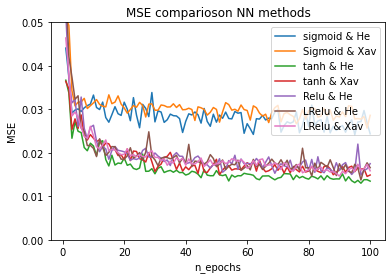

In [124]:
plt.plot(n_epochs, mse_sig_he, label='sigmoid & He')
plt.plot(n_epochs, mse_sig_xav, label='Sigmoid & Xav')
plt.plot(n_epochs, mse_tanh_he, label='tanh & He')
plt.plot(n_epochs, mse_tanh_xav, label='tanh & Xav')
plt.plot(n_epochs, mse_Rel_he, label='Relu & He')
#plt.plot(n_epochs, mse_Rel_xav, label='Relu & Xav')
plt.plot(n_epochs, mse_LRel_he, label='LRelu & He')
plt.plot(n_epochs, mse_LRel_xav, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("MSE")
plt.ylim(0,0.05)
plt.title("MSE comparioson NN methods")
plt.show()



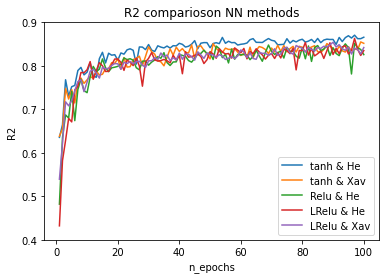

In [123]:
#plt.plot(n_epochs, r2_sig_he, label='sigmoid & He')
#plt.plot(n_epochs, r2_sig_xav, label='Sigmoid & Xav')
plt.plot(n_epochs, r2_tanh_he, label='tanh & He')
plt.plot(n_epochs, r2_tanh_xav, label='tanh & Xav')
plt.plot(n_epochs, r2_Rel_he, label='Relu & He')
#plt.plot(n_epochs, r2_Rel_xav, label='Relu & Xav')
plt.plot(n_epochs, r2_LRel_he, label='LRelu & He')
plt.plot(n_epochs, r2_LRel_xav, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("R2")
plt.ylim(0.4,0.9)
plt.title("R2 comparioson NN methods")
plt.show()



# Comparing now with scikit 

Since Sigmoid underperformed the comparison will be between tanh and Relu of our own network vs that of scikit. 

In [139]:
from sklearn.neural_network import MLPRegressor

In [147]:

sickit_tanh_r2=[]
sickit_Rel_r2 = []
for i in range(len(n_epochs)):
    epoch = n_epochs[i]
    regr_tanh = MLPRegressor(random_state=1,alpha = lmb_tanh_he,activation="tanh",batch_size=batch_size, max_iter=epoch,learning_rate_init=eta,solver="lbfgs").fit(X_train, z_train)
    regr_tanh.predict(X_test)
    
    regr_Relu = MLPRegressor(random_state=1,alpha = lmb_Rel_he,activation="relu",batch_size=batch_size, max_iter=epoch,learning_rate_init=eta,solver ="lbfgs").fit(X_train, z_train)
    regr_Relu.predict(X_test)
    
    sickit_tanh_r2.append(regr_tanh.score(X_test,z_test))
    sickit_Rel_r2.append(regr_Relu.score(X_test,z_test))




C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Lasse\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

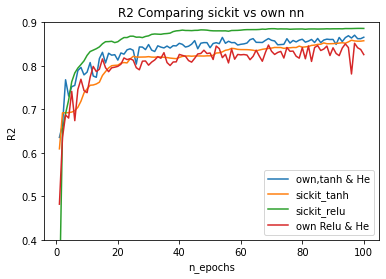

In [148]:
#plt.plot(n_epochs, r2_sig_he, label='sigmoid & He')
#plt.plot(n_epochs, r2_sig_xav, label='Sigmoid & Xav')
plt.plot(n_epochs, r2_tanh_he, label='own,tanh & He')
plt.plot(n_epochs, sickit_tanh_r2, label='sickit_tanh')
plt.plot(n_epochs, sickit_Rel_r2, label='sickit_relu')
plt.plot(n_epochs, r2_Rel_he, label='own Relu & He')
#plt.plot(n_epochs, r2_LRel_he, label='LRelu & He')
#plt.plot(n_epochs, r2_LRel_xav, label='LRelu & Xav')
plt.legend()
plt.xlabel("n_epochs")
plt.ylabel("R2")
plt.ylim(0.4,0.9)
plt.title("R2 Comparing sickit vs own nn")
plt.show()

